Data Cleaning - Aggregated Airbnb Calendar Data

# Introduction

In the following notebook, I will be cleaning an aggregation of Airbnb's calendar data of the San Francisco area. This data consists of data from 1/2018 through 12/2019.

* The aggregation source code [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/blob/master/Airbnb%20Raw%20Data%20Aggregation.ipynb)

* Raw data [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Data/01_Raw/SF%20Airbnb%20Raw%20Data)

## Read in libraries, set notebook preferences, and read in data

In [1]:
#Read in libraries
import dask.dataframe as dd
import swifter
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

**Settings for Notebook**

In [41]:
#Set Pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#Set plot style
plt.style.use('ggplot')

**Read in Data**

In [3]:
#Set path to get aggregated calendar data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\01_Raw\SF Airbnb Raw Data\SF Airbnb Raw Data - Aggregated\01_04_2020_Calendar_Raw_Aggregated.csv'

#Set date columns for parsing
parse_dates = ['date']

#Read in calendar data
calendar = pd.read_csv(path, sep = ',', dtype = {"listing_id" : "object"}, parse_dates=parse_dates,index_col=0, low_memory=False)

C:\Users\kishe\Miniconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Preview Data

In [4]:
#Preview calendar data
display(calendar.head())

,adjusted_price,available,date,listing_id,maximum_nights,minimum_nights,price
0,NaN,t,2019-04-05,21190709,NaN,NaN,"$5,000.00"
1,NaN,t,2019-04-04,21190709,NaN,NaN,"$5,000.00"
2,NaN,t,2019-04-03,21190709,NaN,NaN,"$5,000.00"
3,NaN,t,2019-04-02,21190709,NaN,NaN,"$5,000.00"
4,NaN,t,2019-04-01,21190709,NaN,NaN,"$5,000.00"


In [5]:
#Print shape and dtypes of calendar data
print('Calendar data shape:',calendar.shape)
print('\nCalendar data types: \n',calendar.dtypes)

Calendar data shape: (26178939, 7)

Calendar data types: 
 adjusted_price            object
available                 object
date              datetime64[ns]
listing_id                object
maximum_nights           float64
minimum_nights           float64
price                     object
dtype: object


# Data Cleaning

## Drop columns not needed for Time Series Analysis

In [6]:
#Drop columns not needed for time series analysis
calendar.drop(columns = ['adjusted_price','maximum_nights','minimum_nights','listing_id'], inplace = True)

#View
display(calendar)

,available,date,price
0,t,2019-04-05,"$5,000.00"
1,t,2019-04-04,"$5,000.00"
2,t,2019-04-03,"$5,000.00"
3,t,2019-04-02,"$5,000.00"
4,t,2019-04-01,"$5,000.00"
...,...,...,...
61385197,f,2020-09-06,$255.00
61385198,f,2020-09-07,$342.00
61385199,f,2020-09-08,$455.00
61385200,f,2020-09-09,$522.00


## Column cleaning and data type correction

**Price column**

In [7]:
#Remove $ and , from price 
calendar['price']=calendar['price'].replace('[,$]','', regex=True)

#Convert string to numeric
calendar['price'] =calendar['price'].swifter.apply(pd.to_numeric, errors='coerce')

**Available column**

In [8]:
#Replace 't' and 'f' in available column to True and False
calendar.available = calendar.available.swifter.apply(lambda x:  1 if x =='t' else 0)

C:\Users\kishe\Miniconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Missing Data

**Stats of missing values per column**

In [9]:
#Create function that captures missing data stats of a pandas df
def missing_stats(pandas):
    #Create empty dataframe to store missing value stats in
    missing = pd.DataFrame()
    #Capture total number and total % of missing data per column
    missing['Total'] = pandas.isnull().sum().sort_values(ascending=False)
    missing['Percent'] = (missing['Total']/pandas.isnull().count()).apply(lambda x: x * 100)
    return missing

#Check
missing_stats(calendar)

,Total,Percent
price,4837396,18.478197
date,0,0.000000
available,0,0.000000


**View rows with missing price values**

In [10]:
calendar[calendar['price'].isnull()]

,available,date,price
1146,0,2018-11-03,NaN
1147,0,2018-11-02,NaN
1148,0,2018-11-01,NaN
1149,0,2018-10-31,NaN
1150,0,2018-10-30,NaN
...,...,...,...
58489652,0,2019-09-03,NaN
58489653,0,2019-09-04,NaN
58489654,0,2019-09-05,NaN
58489655,0,2019-09-06,NaN


It appears that if available is false, price will be missing. 

In [18]:
#Capture rows with missing price data and assign to df
missing_price = calendar[calendar['price'].isnull()]

#View 
print('Missing values with availability: ', len(missing_price[missing_price.available == 1]))
print('Missing values w/o availability: ', len(missing_price[missing_price.available == 0]))

Missing values with availability:  322
Missing values w/o availability:  4837074


**Drop rows with missing values and available is false**

In [20]:
#Get indeces of rows with missing values in price and available == 0
remove = missing_price[missing_price.available == 0].index.tolist()

#Drop
calendar = calendar.drop(remove)

#Check calendar shape
print('Current calendar data shape:',calendar.shape)

#View updated missing stats
missing_stats(calendar)

Current calendar data shape: (21341865, 3)


,Total,Percent
price,322,0.001509
date,0,0.000000
available,0,0.000000


**Replace remaining missing values with median of price**

In [25]:
#Fill remaining na with median of price column
calendar['price'] = calendar['price'].fillna(calendar['price'].median())

#View updated missing stats
missing_stats(calendar)

,Total,Percent
price,0,0.0
date,0,0.0
available,0,0.0


## Outliers

In [43]:
#How many evenings are available for rent for over 5,000?
calendar['price'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,.95,.99])

count   21341865.00
mean         230.78
std          600.20
min            0.00
10%           71.00
20%           94.00
30%          115.00
40%          136.00
50%          159.00
60%          186.00
70%          220.00
80%          278.00
90%          400.00
95%          590.00
99%         1252.00
max       220713.00
Name: price, dtype: float64

In [36]:
print(calendar.price.mean())
print(calendar.price.median())


230.78475180121325
159.0


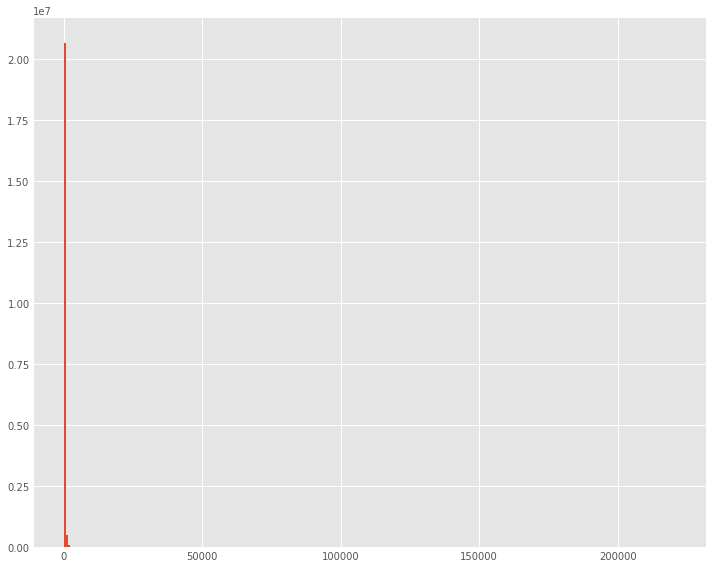

In [29]:
#Display distributions of calendar data
calendar['price'].hist( figsize=(10,8), bins = 300);
plt.show()



#### Price Outlier Removal

**Identify and remove outliers using IQR**

Removing outliers from price should normalize both price and adjusted_price columns.

In [15]:
# #Calculate IQR of price
# q25 = calendar['price'].quantile(0.25)
# q75= calendar['price'].quantile(0.75)
# iqr = q75 - q25

# #Print percentiles
# print('Percentiles: 25th={:.3f}, 75th={:.3f} \nIQR= {:.3f}'.format(q25, q75, iqr))

# #Calculate outlier cutoffs
# cut_off =1.5 * iqr
# lower, upper = q25 - cut_off, q75 + iqr

# #Identify outliers
# outliers = [x for x in calendar.price if x < lower or x > upper]
# print("Number of outliers identified: {}".format(len(outliers)))

# #Remove outliers
# outliers_removed = [x for x in calendar.price if x >= lower and x <= upper]
# print('Non-outlier observations: {}'.format(len(outliers_removed)))

# #Update df
# calendar = calendar[calendar.price.isin(outliers_removed)]

New calendar shape:  (26178939, 3)


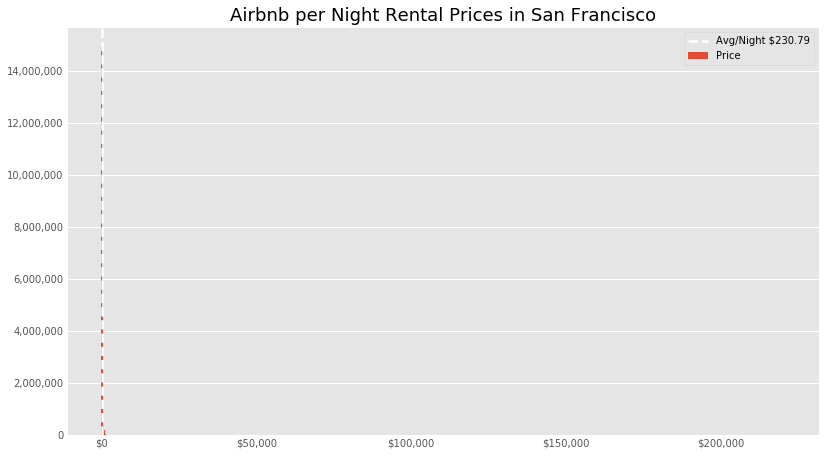

In [16]:
#Updated calendar Shape
print('New calendar shape: ', calendar.shape)

#Set ggplot plot style
plt.style.use('ggplot')

#Plot updated prices from calendar data
plot = calendar.price.plot(kind = 'hist', bins=1000, figsize=(12,7), label = 'Price',
                   legend = True)

#Get plot object
ax = plt.gca()

#Capture mean
mean = np.mean(calendar.price)

#Plot mean and median to histogram
ax.axvline(mean, color='white', linestyle='dashed', linewidth=2.5, label = "Avg/Night ${:}".format(str(round(mean,2))))

#Format x-axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

#Format y ticks
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_ylabel('')

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

#Set Title
ax.set_title('Airbnb per Night Rental Prices in San Francisco', fontweight= 'normal', fontsize = 18)

#Show legend
plt.legend(frameon = True, loc='upper right');

#Save plot to png
# fig = plot.get_figure()
# fig.savefig(path + '\Airbnb per Night Rental Prices in San Francisco.png',bbox_inches = 'tight')

In [17]:
#Set path to write listings
# path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate\01_04_2020_Calendar_Cleaned.csv'

# #Write listings to path
# calendar.to_csv(path, sep=',')